# Fingerprint Recognition

## Information
- dataset : https://www.kaggle.com/ruizgara/socofing  
- reference source : https://www.kaggle.com/prasanjeetkeshriii/biometrics-project
- blog : https://yscho03.tistory.com/83https://yscho03.tistory.com/83

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.models import Model
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2

import os
import random

Using TensorFlow backend.


In [2]:
BASE_DIR = os.getcwd()
DATASET_DIR = os.path.join(BASE_DIR, 'datasets', 'SOCOFing')

ALTERED_PREFIX_DIR = os.path.join(DATASET_DIR, 'Altered', 'Altered-')
REAL_DIR = os.path.join(DATASET_DIR, 'Real')

## Load Dataset

In [3]:
def load_data(path, train=True, img_size=90):
    print(">>> Loading directory: ", path)
    
    gender_indexes = ['m', 'f']
    lr_indexes = ['left', 'right']
    finger_indexes = ['thumb', 'index', 'middle', 'ring', 'little']    
    
    images = []
    labels = []
    
    for img in os.listdir(path):
        
        imgname, ext = os.path.splitext(img)
        ID, etc = imgname.split('__')
        ID = int(ID) - 1
        
        etc = etc.lower()        
        if train:
            gender, lr, finger, _, _ = etc.split('_')
        else:
            gender, lr, finger, _  = etc.split('_')
                
        gender_index = gender_indexes.index(gender)
        lr_index = lr_indexes.index(lr)
        finger_index = finger_indexes.index(finger)
        
        # ID + gender + lef, right + finger index
        label = np.array([ID, gender_index, lr_index, finger_index])
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        img_resize = cv2.resize(img_array, (img_size, img_size))         
        img_resize = img_resize.reshape(img_size, img_size, 1)
        
        images.append(img_resize)
        labels.append(label)
        
    return images, labels

In [4]:
x_real, y_real = load_data(REAL_DIR, train=False)
x_easy, y_easy = load_data(ALTERED_PREFIX_DIR + 'Easy', train=True)
x_medium, y_medium = load_data(ALTERED_PREFIX_DIR + 'Medium', train=True)
x_hard, y_hard = load_data(ALTERED_PREFIX_DIR + 'Hard', train=True)

>>> Loading directory:  D:\projects\research\fingerprint_recognition\datasets\SOCOFing\Real
>>> Loading directory:  D:\projects\research\fingerprint_recognition\datasets\SOCOFing\Altered\Altered-Easy
>>> Loading directory:  D:\projects\research\fingerprint_recognition\datasets\SOCOFing\Altered\Altered-Medium
>>> Loading directory:  D:\projects\research\fingerprint_recognition\datasets\SOCOFing\Altered\Altered-Hard


In [5]:
x_real[0].shape, y_real[0].shape

((90, 90, 1), (4,))

In [6]:
def show_images(sample_data):
    _, ax = plt.subplots(1, 4, figsize=(15, 10))
    for i, data in enumerate(sample_data):    
        category = data[0]
        img_array = data[1]    
        img_title = data[2]    
        ax[i].set_title(category + ': ' + str(img_title))
        ax[i].imshow(img_array, cmap='gray')

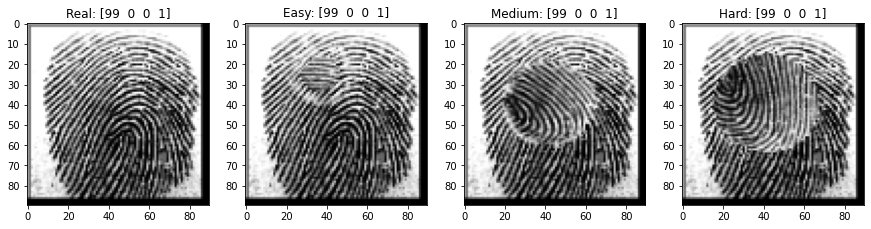

In [7]:
sample_data = [('Real', x_real[0], y_real[0]), ('Easy', x_easy[0], y_easy[0]), ('Medium', x_medium[0], y_medium[0]), ('Hard', x_hard[0], y_hard[0])]
show_images(sample_data)

### Train Test Split

In [8]:
x_data = np.concatenate([x_easy, x_medium, x_hard], axis=0)
label_data = np.concatenate([y_easy, y_medium, y_hard], axis=0)

x_train, x_val, label_train, label_val = train_test_split(x_data, label_data, test_size=0.1)

print(x_data.shape, label_data.shape)
print(x_train.shape, label_train.shape)
print(x_val.shape, label_val.shape)

(49270, 90, 90, 1) (49270, 4)
(44343, 90, 90, 1) (44343, 4)
(4927, 90, 90, 1) (4927, 4)


### Preview Augmentation

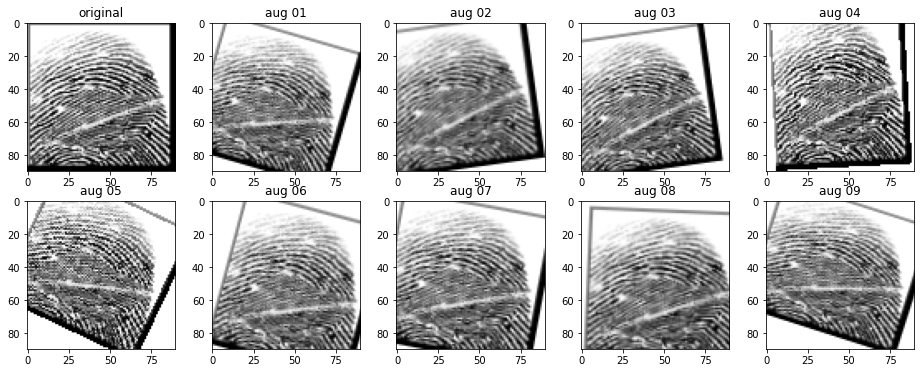

In [9]:
augs = [x_data[40000]] * 9

seq = iaa.Sequential([
    # blur images with a sigma of 0 to 0.5
    iaa.GaussianBlur(sigma=(0, 0.5)),
    iaa.Affine(
        # scale images to 90-110% of their size, individually per axis
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
        # translate by -10 to +10 percent (per axis)
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        # rotate by -30 to +30 degrees
        rotate=(-30, 30),
        # use nearest neighbour or bilinear interpolation (fast)
        order=[0, 1],
        # if mode is constant, use a cval between 0 and 255
        cval=255
    )
], random_order=True)

augs = seq.augment_images(augs)

plt.figure(figsize=(16, 6))
plt.subplot(2, 5, 1)
plt.title('original')
plt.imshow(x_data[40000].squeeze(), cmap='gray')
for i, aug in enumerate(augs):
    plt.subplot(2, 5, i+2)
    plt.title('aug %02d' % int(i+1))
    plt.imshow(aug.squeeze(), cmap='gray')

### Make Label Dictionary Lookup Table

In [10]:
label_real_dict = {}

for i, y in enumerate(y_real):
    key = y.astype(str)
    key = ''.join(key).zfill(6)
    label_real_dict[key] = i

### Data Generator

In [11]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, x, label, x_real, label_real_dict, batch_size=32, shuffle=True):
        'Initialization'
        self.x = x
        self.label = label
        self.x_real = x_real
        self.label_real_dict = label_real_dict
        
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.x) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        x1_batch = self.x[index*self.batch_size:(index+1)*self.batch_size]
        label_batch = self.label[index*self.batch_size:(index+1)*self.batch_size]
        
        x2_batch = np.empty((self.batch_size, 90, 90, 1), dtype=np.float32)
        y_batch = np.zeros((self.batch_size, 1), dtype=np.float32)
        
        # augmentation
        if self.shuffle:
            seq = iaa.Sequential([
                iaa.GaussianBlur(sigma=(0, 0.5)),
                iaa.Affine(
                    scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
                    translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
                    rotate=(-30, 30),
                    order=[0, 1],
                    cval=255
                )
            ], random_order=True)

            x1_batch = seq.augment_images(x1_batch)
        
        # pick matched images(label 1.0) and unmatched images(label 0.0) and put together in batch
        # matched images must be all same, [subject_id(3), gender(1), left_right(1), finger(1)], e.g) 034010
        for i, l in enumerate(label_batch):
            match_key = l.astype(str)
            match_key = ''.join(match_key).zfill(6)

            if random.random() > 0.5:
                # put matched image
                x2_batch[i] = self.x_real[self.label_real_dict[match_key]]
                y_batch[i] = 1.
            else:
                # put unmatched image
                while True:
                    unmatch_key, unmatch_idx = random.choice(list(self.label_real_dict.items()))

                    if unmatch_key != match_key:
                        break

                x2_batch[i] = self.x_real[unmatch_idx]
                y_batch[i] = 0.

        return [x1_batch.astype(np.float32) / 255., x2_batch.astype(np.float32) / 255.], y_batch

    def on_epoch_end(self):
        if self.shuffle == True:
            self.x, self.label = shuffle(self.x, self.label)

In [12]:
train_gen = DataGenerator(x_train, label_train, x_real, label_real_dict, shuffle=True)
val_gen = DataGenerator(x_val, label_val, x_real, label_real_dict, shuffle=False)

### Build Model

In [13]:
x1 = layers.Input(shape=(90, 90, 1))
x2 = layers.Input(shape=(90, 90, 1))

# share weights both inputs
inputs = layers.Input(shape=(90, 90, 1))

feature = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(inputs)
feature = layers.MaxPooling2D(pool_size=2)(feature)

feature = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(feature)
feature = layers.MaxPooling2D(pool_size=2)(feature)

feature_model = Model(inputs=inputs, outputs=feature)

# 2 feature models that sharing weights
x1_net = feature_model(x1)
x2_net = feature_model(x2)

# subtract features
net = layers.Subtract()([x1_net, x2_net])

net = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(net)
net = layers.MaxPooling2D(pool_size=2)(net)

net = layers.Flatten()(net)
net = layers.Dense(64, activation='relu')(net)
net = layers.Dense(1, activation='sigmoid')(net)

model = Model(inputs=[x1, x2], outputs=net)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 90, 90, 1)    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 90, 90, 1)    0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 22, 22, 32)   9568        input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
subtract_1 (Subtract)           (None, 22, 22, 32)   0           model_1[1][0]              

### Train

In [14]:
history = model.fit_generator(train_gen, epochs=10, validation_data=val_gen)

Epoch 1/10
1385/1385 [==============================] - 44s 31ms/step - loss: 0.2218 - acc: 0.9074 - val_loss: 0.0296 - val_acc: 0.9912
Epoch 2/10
1385/1385 [==============================] - 33s 24ms/step - loss: 0.1118 - acc: 0.9577 - val_loss: 0.0037 - val_acc: 0.9929
Epoch 3/10
1385/1385 [==============================] - 32s 23ms/step - loss: 0.0860 - acc: 0.9687 - val_loss: 0.0100 - val_acc: 0.9941
Epoch 4/10
1385/1385 [==============================] - 32s 23ms/step - loss: 0.0716 - acc: 0.9737 - val_loss: 0.0054 - val_acc: 0.9973: 0.0717 - 
Epoch 5/10
1385/1385 [==============================] - 32s 23ms/step - loss: 0.0655 - acc: 0.9765 - val_loss: 9.0817e-04 - val_acc: 0.9965
Epoch 6/10
1385/1385 [==============================] - 32s 23ms/step - loss: 0.0567 - acc: 0.9800 - val_loss: 0.0176 - val_acc: 0.9957
Epoch 7/10
1385/1385 [==============================] - 32s 23ms/step - loss: 0.0535 - acc: 0.9817 - val_loss: 0.0014 - val_acc: 0.9986
Epoch 8/10
1385/1385 [===========

### Evaluation

In [15]:
# new user fingerprint input
random_idx = random.randint(0, len(x_val))

random_img = x_val[random_idx]
random_label = label_val[random_idx]

seq = iaa.Sequential([
    iaa.GaussianBlur(sigma=(0, 0.5)),
    iaa.Affine(
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        rotate=(-30, 30),
        order=[0, 1],
        cval=255
    )
], random_order=True)

random_img = seq.augment_image(random_img).reshape((1, 90, 90, 1)).astype(np.float32) / 255.

# matched image
match_key = random_label.astype(str)
match_key = ''.join(match_key).zfill(6)

rx = x_real[label_real_dict[match_key]].reshape((1, 90, 90, 1)).astype(np.float32) / 255.
ry = y_real[label_real_dict[match_key]]

pred_rx = model.predict([random_img, rx])

# unmatched image
unmatch_key, unmatch_idx = random.choice(list(label_real_dict.items()))

ux = x_real[unmatch_idx].reshape((1, 90, 90, 1)).astype(np.float32) / 255.
uy = y_real[unmatch_idx]

pred_ux = model.predict([random_img, ux])

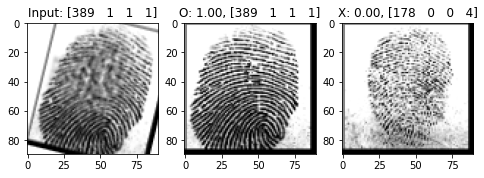

In [16]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 3, 1)
plt.title('Input: %s' %random_label)
plt.imshow(random_img.squeeze(), cmap='gray')
plt.subplot(1, 3, 2)
plt.title('O: %.02f, %s' % (pred_rx, ry))
plt.imshow(rx.squeeze(), cmap='gray')
plt.subplot(1, 3, 3)
plt.title('X: %.02f, %s' % (pred_ux, uy))
plt.imshow(ux.squeeze(), cmap='gray')

## Save Model

In [17]:
checkpoint_save_path = os.path.join(BASE_DIR, 'checkpoint', 'FingerPrintCNN.h5')
model.save(checkpoint_save_path)